In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

DATA_DIR = "data"
DATA_FILE = "data.csv"

sns.set()

In [2]:
df = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE))
df.head()

,rank,true_value,params,ppf025,ppf975,sim_no,estimator
0,0,-0.170757,-0.397254,-0.776187,-0.018321,4,projection
1,1,-0.262514,-0.330480,-0.624541,-0.036419,4,projection
2,2,-0.391383,-0.328064,-0.692552,0.036424,4,projection
3,3,-0.247814,-0.295812,-0.609829,0.018205,4,projection
4,4,-0.277869,-0.288085,-0.631167,0.054997,4,projection


In [3]:
df["coverage"] = ((df.ppf025 <= df.true_value) & (df.true_value <= df.ppf975))
df["probability_bias"] = (df.params > df.true_value).astype(int) - .5
df["len_ci"] = df.ppf975 - df.ppf025
df["mae"] = abs(df.params - df.true_value)
df.head()

,rank,true_value,params,ppf025,ppf975,sim_no,estimator,coverage,probability_bias,len_ci,mae
0,0,-0.170757,-0.397254,-0.776187,-0.018321,4,projection,True,-0.5,0.757866,0.226497
1,1,-0.262514,-0.330480,-0.624541,-0.036419,4,projection,True,-0.5,0.588123,0.067966
2,2,-0.391383,-0.328064,-0.692552,0.036424,4,projection,True,0.5,0.728976,0.063319
3,3,-0.247814,-0.295812,-0.609829,0.018205,4,projection,True,-0.5,0.628034,0.047998
4,4,-0.277869,-0.288085,-0.631167,0.054997,4,projection,True,-0.5,0.686164,0.010216


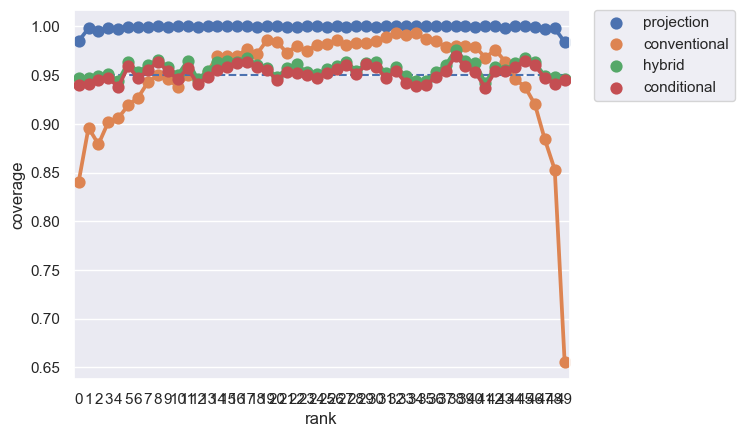

In [8]:
ax = sns.pointplot(
    data=df,
    x="rank",
    y="coverage",
    hue="estimator",
    ci=None
)
ax.axhline(.95, linestyle="--")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

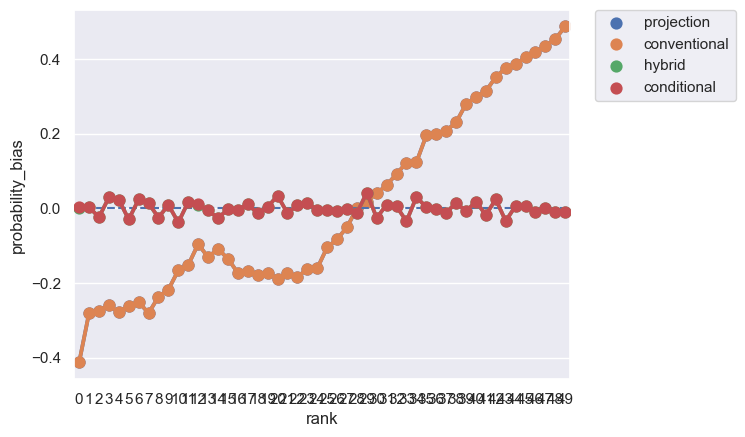

In [9]:
ax = sns.pointplot(
    data=df,
    x="rank",
    y="probability_bias",
    hue="estimator",
    ci=None
)
ax.axhline(0, linestyle="--")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

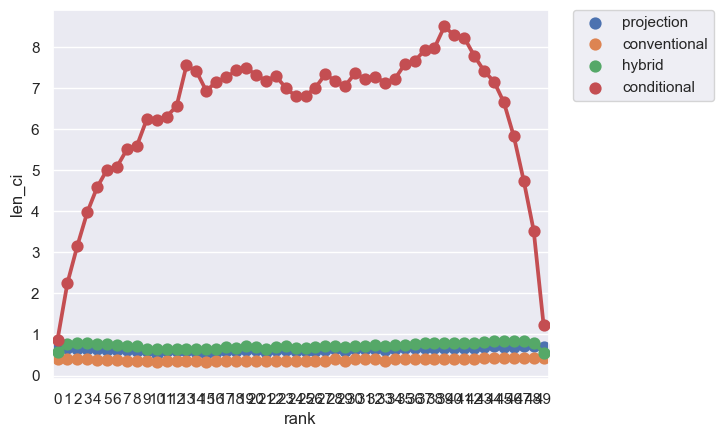

In [13]:
sns.pointplot(
    data=df,
    x="rank",
    y="len_ci",
    hue="estimator",
    estimator=lambda x: np.quantile(x, .5),
    ci=None
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

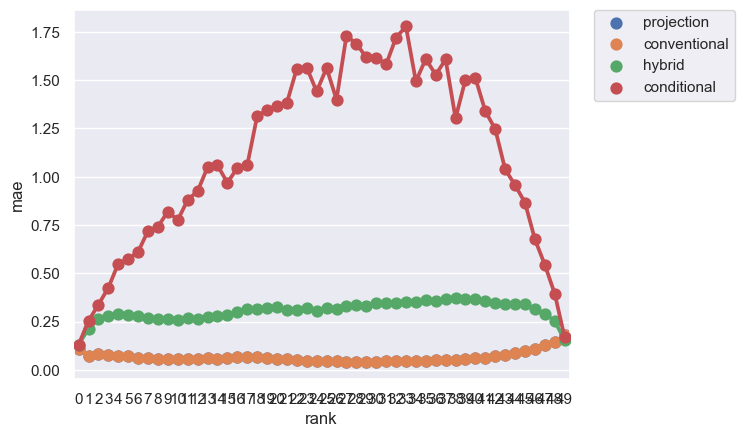

In [14]:
sns.pointplot(
    data=df,
    x="rank",
    y="mae",
    hue="estimator",
    estimator=lambda x: np.quantile(x, .5),
    ci=None
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()